## 2021321148 insik cho

In [83]:
# I installed needed packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numba import jit
import networkx as nx

import time

from itertools import combinations, permutations
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings(action='ignore')

## 0. data loading

In [75]:
# adjacency matrix 데이터를 삽입할 dataframe을 정의합니다. 
df = np.zeros((34,34))

# 본래 list로 작성된 adjacency data를 행려롤 전환
with open("karate_club.adjlist") as file:
    for _ in range(3):
        next(file)
        
# 파일의 줄마다 pair를 찾고 있을 시 1을 부여
    for line in file:
        node = list(map(int, line.split()))
        i = node[0]
        for j in node[1:]:
            df[i][j] = 1
            df[j][i] = 1
    file.close()
    
label = np.loadtxt("karate_label.txt")

In [76]:
# read edge
edge = [] # list of tuples
with open("./karate_club.edgelist") as file:
    for line in file:
#         print(line)
        i, j, _ = line.split()
        edge.append((int(i), int(j)))
        
p = np.zeros(df.shape[0])
for i, j in edge:
    p[i] += 1
    p[j] += 1
pp = p/(len(edge)*2)


## 1. LINE class with negative sampling 

In [77]:
class LINE_negative_sampling():
    
    def __init__(self,random_state = 42, epochs = 500):
        self.random_state = random_state
        self.epochs = epochs 
        
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def noise_distribution(self,df):
        p = []
        for i in range(len(df)):
            p_i = []
            s=0
            for j in range(len(df)):
                d = list(df[j])
                d.pop(i)
                d = np.array(d)
                p_i.append(np.sum(d[d==1.0])**(3/4))
                s+=np.sum(d[d==1.0])**(3/4)
            p_i = p_i/s
            p.append(p_i)
        return p 

        
    def first_prox(self,df,hidden_size=2,lr = 0.02, K=5):
        input_size = df.shape[0]

        # 초기값 설정. 그냥 normal에서 랜덤추출.
        np.random.seed(self.random_state)
        self.embedding_matrix_first = np.random.normal(0,0.05,[input_size,hidden_size])

        # ij pair index. first order에서
        # edge마다 연결해야 하므로, 랜덤으로 추출할 수 있는 matrix 형성
        index = np.arange(0,input_size)
        # 2개씩 랜덤으로 뽑아내는 방식으로 combination 함수 사용.
        edge = list(combinations(index,2))
        np.random.shuffle(edge)
        
        # noise distribution 생성
        noise = self.noise_distribution(df)
        
                 

        # 해당 함수를 통해 도출되는 값은 embedding matrix와
        # 해당 훈련과정에서 발생하는 cost. cost는 해당 함수의 결과로 반환하도록 설정.
        cost = []
        for epoch in range(self.epochs):
            # edge마다 u_i와 u_j의 로지스틱 함수(비용)을 극소화하기 위해 
            # 앞서 정한 모든 (i,j) edge에 대해 u_i와 u_j를 설정하고
            # 이를 각각 업데이트 합니다. 
            error=0
            for k in range(len(edge)):
                i = edge[k][0]
                j = edge[k][1]
                neg = []
                while len(neg)<K:
                    choice = np.random.choice(list(range(input_size)),1, p=noise[i])
                    if (choice !=i) and (choice !=j) and (choice in np.where(df[i]==0)[0]):
                        neg.append(choice)

                ui = self.embedding_matrix_first[i]
                uj = self.embedding_matrix_first[j]
                #가중치가 없으므로, 연결이 되면 1, 아되면 0으로 w_ij 를 대입.

                # 확률은 시그모이드 사용.
                p1 = self.sigmoid(uj @ ui)
                error -=  np.log(p1)
                unn = 0
                for n in neg:
                    un = self.embedding_matrix_first[n]
                    pn = self.sigmoid(- un @ ui)
                    g_un =(1-pn)*ui
                    unn+=(1-pn)*un
                    un -= lr*g_un
                    error -= np.log(pn)
                    
                # gradient
                g_ui = -((1-p1)*uj -unn)
                g_uj = -((1-p1)*ui)
                # update
                ui -= wij*lr*g_ui.reshape(2,)
                uj -= wij*lr*g_uj           
 
            cost.append(error)
        return cost
    
    def second_prox(self, df,hidden_size=2,lr = 0.02,K=5):
        input_size = df.shape[0]

        # 초기값 설정
        # second approx에서는 context도 해야하므로 context도 초깃값 설정
        np.random.seed(self.random_state)
        self.embedding_matrix_second = np.random.normal(0,0.1,[input_size,hidden_size])
        self.context_matrix =  np.random.normal(0,0.1,[input_size,hidden_size])

        # combination 적용하여 pair list 생성
        # 1st와는 다르게 permutation을 적용했는데, 수식상 모든 embedding matrix와의
        # 식을 적어야 하기 때문.
        index = np.arange(0,input_size)
        edge = list(permutations(index,2))
        np.random.shuffle(edge)
        
        # noise distribution을 만든다.
        noise = self.noise_distribution(df)

        cost = []
        for epoch in range(self.epochs):
            error=0
            # edge마다 u_i와 u_j의 로지스틱 함수(비용)을 극소화하기 위해 
            # 앞서 정한 모든 (i,j) edge에 대해 u_i와 u_j를 설정하고
            # 이를 각각 업데이트 합니다. 
            for k in range(len(edge)):
                i = edge[k][0]
                j = edge[k][1]
                # ij pair
                # noise distribution을 바탕으로 negative sampling을진행.
                neg = []
                while len(neg)<K:
                    choice = np.random.choice(list(range(input_size)),1, p=noise[i])
                    if (choice !=i)  and (choice !=i)and (choice in np.where(df[i]==0)[0]):
                        neg.append(choice)

                #  embedding matrix와 context matrix
                ui = self.embedding_matrix_second[i]
                uj = self.context_matrix[j]
                wij = df[i,j]
                # 가중치가 없으므로, 연결이 되면 1, 아되면 0으로 w_ij 를 대입.
                
                # context에 대한 gradient_j를 계산. 간단한 형태이기 때문에 먼저 한다. 
                p2 = self.sigmoid(ui @ uj)
              
                                        
                # negative sample 미분 시의 정보를 모은다.
                g_un = 0
                g_ui = (p2-1)*uj
                for n in neg:
                    un = self.context_matrix[n]
                    n2 = self.sigmoid(ui @ un.T)
                    error -= np.log(1-n2)
                    # 매 neg.sample. 마다 ui를 업데이트 한다.                    
                    g_ui += n2 * un.reshape(2,)
                    g_vn = n2 * ui
                    self.context_matrix[n] -= lr * g_vn
                
                error -= np.log(p2)
                ui -= wij*lr * g_ui
                uj-= wij*lr*((p2-1)*ui)
    
            cost.append(error)

        return cost
    
    # concatenation의 경우, 과제 요구사항에는 없지만 한번 해봤습니다.
    # 원 논문에 따르면 두 embedding vector를 concatenation하는 것만으로도
    # 충분한 성능이 나온다고 합니다. 
    def train(self, df,hidden_size=2,lr = 0.02):
        self.first_prox(df, hidden_size = hidden_size, lr = lr)
        self.second_prox(df, hidden_size = hidden_size, lr = lr)
        self.embedding_line =  np.concatenate((self.embedding_matrix_first,self.embedding_matrix_second),axis=1)
        return self.embedding_line
        

##  2. Training & cost 

In [79]:
line = LINE_negative_sampling()
start = time.time()
first_cost = line.first_prox(df, lr = 0.02)
print("소요시간_first: ", (time.time() - start))

소요시간_first:  97.92212009429932


In [80]:
start = time.time()
second_cost = line.second_prox(df, lr = 0.02)
print("소요시간_second: ", (time.time() - start))

소요시간_second:  199.31180143356323


Text(0, 0.5, 'Cost')

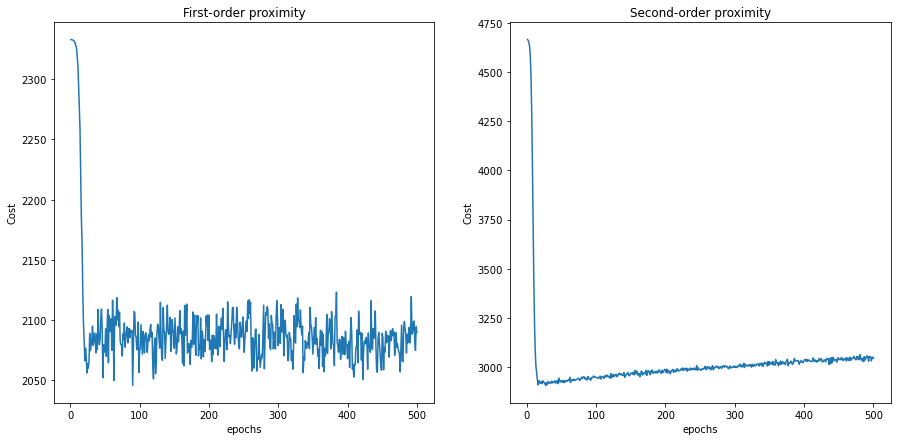

In [81]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
xlim = range(1,501)
plt.plot(xlim,first_cost)
plt.title("First-order proximity")
plt.xlabel("epochs")
plt.ylabel("Cost")

plt.subplot(1,2,2)
xlim = range(1,501)
plt.plot(xlim,second_cost)
plt.title("Second-order proximity")
plt.xlabel("epochs")
plt.ylabel("Cost")


## 3. Comparison

Text(0.5, 1.0, 'karate club network')

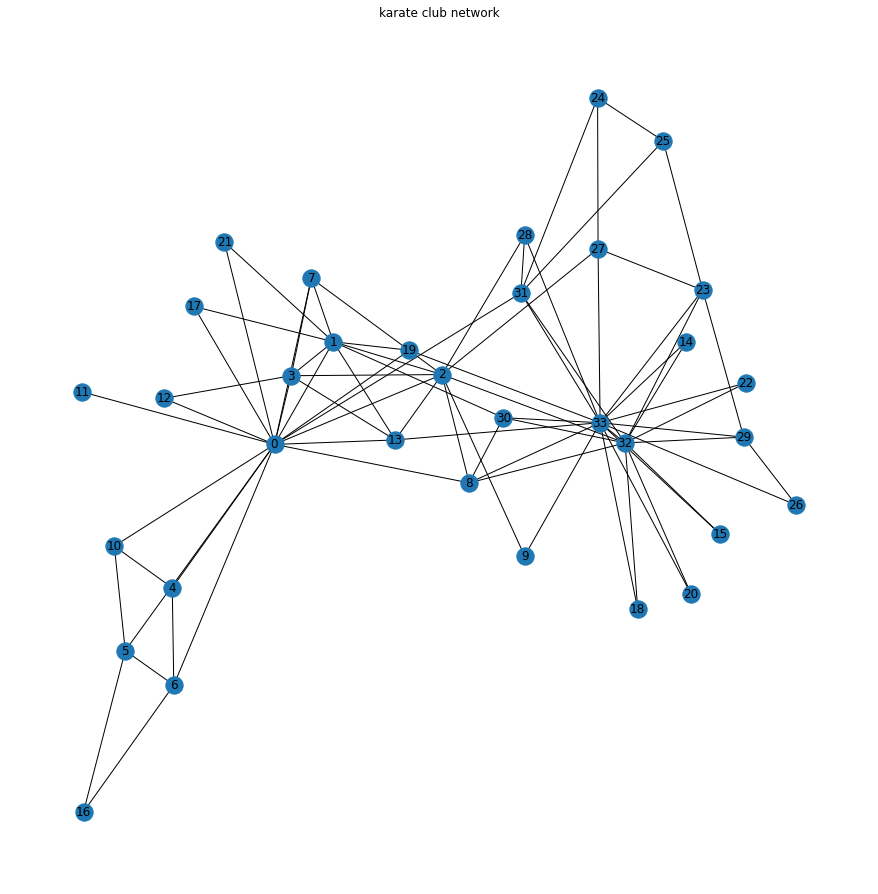

In [84]:
plt.figure(figsize = (12,12))
network = nx.read_adjlist('karate_club.adjlist')
nx.draw(network, with_labels=True) 
plt.title("karate club network")

Text(0.5, 1.0, 'First-order proximity')

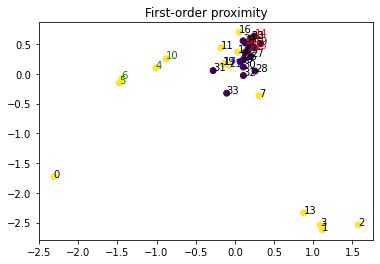

In [85]:

plt.scatter(line.embedding_matrix_first[:,0],line.embedding_matrix_first[:,1],c=label[:,1])
for i in range(df.shape[0]):
    if i in [14,15,18,20,22]:
        plt.text(line.embedding_matrix_first[:,0][i], line.embedding_matrix_first[:,1][i],i, c= 'r')
    elif i in [17,21]:
        plt.text(line.embedding_matrix_first[:,0][i], line.embedding_matrix_first[:,1][i],i, c= 'b')
    elif i in [21,17,7,12]:
        plt.text(line.embedding_matrix_first[:,0][i], line.embedding_matrix_first[:,1][i],i, c= 'g')
    else:
        plt.text(line.embedding_matrix_first[:,0][i], line.embedding_matrix_first[:,1][i],i)
plt.title("First-order proximity")



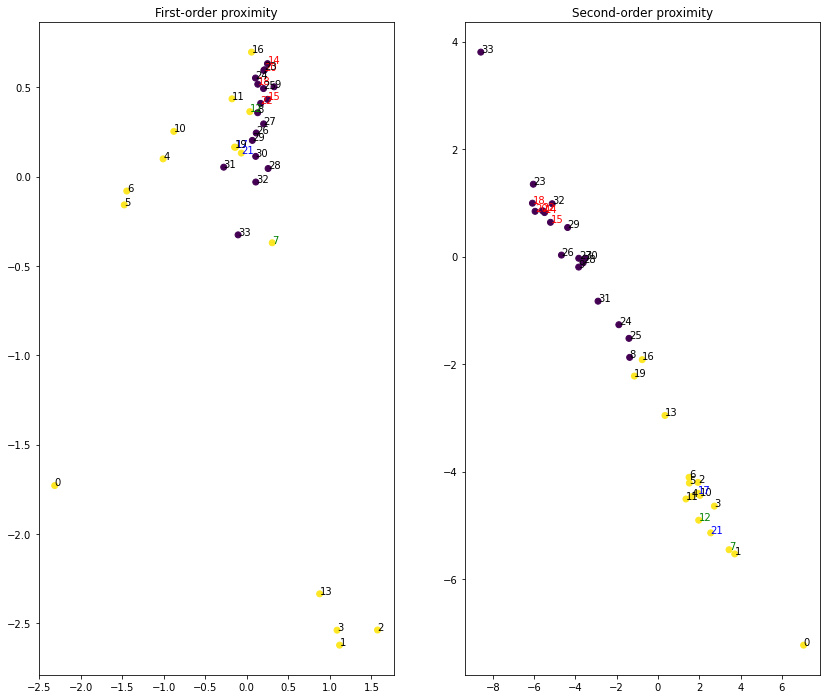

In [87]:
plt.figure(figsize=(14,12))

plt.subplot(1,2,1)
plt.scatter(line.embedding_matrix_first[:,0],line.embedding_matrix_first[:,1],c=label[:,1])
for i in range(df.shape[0]):
    if i in [14,15,18,20,22]:
        plt.text(line.embedding_matrix_first[:,0][i], line.embedding_matrix_first[:,1][i],i, c= 'r')
    elif i in [17,21]:
        plt.text(line.embedding_matrix_first[:,0][i], line.embedding_matrix_first[:,1][i],i, c= 'b')
    elif i in [21,17,7,12]:
        plt.text(line.embedding_matrix_first[:,0][i], line.embedding_matrix_first[:,1][i],i, c= 'g')
    else:
        plt.text(line.embedding_matrix_first[:,0][i], line.embedding_matrix_first[:,1][i],i)
plt.title("First-order proximity")

plt.subplot(1,2,2)
plt.scatter(line.embedding_matrix_second[:,0],line.embedding_matrix_second[:,1],c=label[:,1])
for i in range(df.shape[0]):
    if i in [14,15,18,20,22]:
        plt.text(line.embedding_matrix_second[:,0][i], line.embedding_matrix_second[:,1][i],i, c= 'r')
    elif i in [17,21]:
        plt.text(line.embedding_matrix_second[:,0][i], line.embedding_matrix_second[:,1][i],i, c= 'b')
    elif i in [21,17,7,12]:
        plt.text(line.embedding_matrix_second[:,0][i], line.embedding_matrix_second[:,1][i],i, c= 'g')
    else:
        plt.text(line.embedding_matrix_second[:,0][i], line.embedding_matrix_second[:,1][i],i)
plt.title("Second-order proximity")
plt.show()

- cost function이 빠르게 수렴하는 듯한 모습을 보였지만, first proximity의 경우 기존처럼 분류를 잘 하지는 못했습니다. 

- second proximity의 경우 assignment 8에서는 266초가 걸린데 반해, 여기서느 199초가 걸려 확연히 빨라진 모습을 보였습니다.

- assignment8에서 비교군으로 제시한 [14,15,18,20,22], [17,21]와 [4,5,6,10]은 여기서는 first, second 모두 잘 밀집된 모습을 보였습니다.

- 대신 7,12,17,21 군을 비교군으로 제시하고 싶습니다. 7 같은 경우 direct relation은 없지만 12,17,21과 같은 노드를 여러개 공유합니다.

- first에서는 이를 잡아내지 못해 나머지 3 점과 다소 떨어졌지만, second 에서는 붙어있는 모습이 나타납니다.

- first proximity의 훈련에 의문이 생기긴 하지만, 수업시간에 배운 내용을 전체적으로 뒷받침하는 모습으로 나타났습니다.